
Best Hybrid Optimization Line:
Parameters: Magnitude = 9.00, Length scale = 8.00, Angle = 74.00 degrees
Hybrid Score: -33.98
Log-Likelihood: -57.38
BPR-25: 0.4680
Best Log-Likelihood Line:
Parameters: Magnitude = 8.00, Length scale = 20.00, Angle = 105.00 degrees
Log-Likelihood: -50.69
BPR-25: 0.2989

Best BPR-K Line:
Parameters: Magnitude = 1.00, Length scale = 5.00, Angle = 72.00 degrees
BPR-25: 0.4800
Log-Likelihood: -63.34


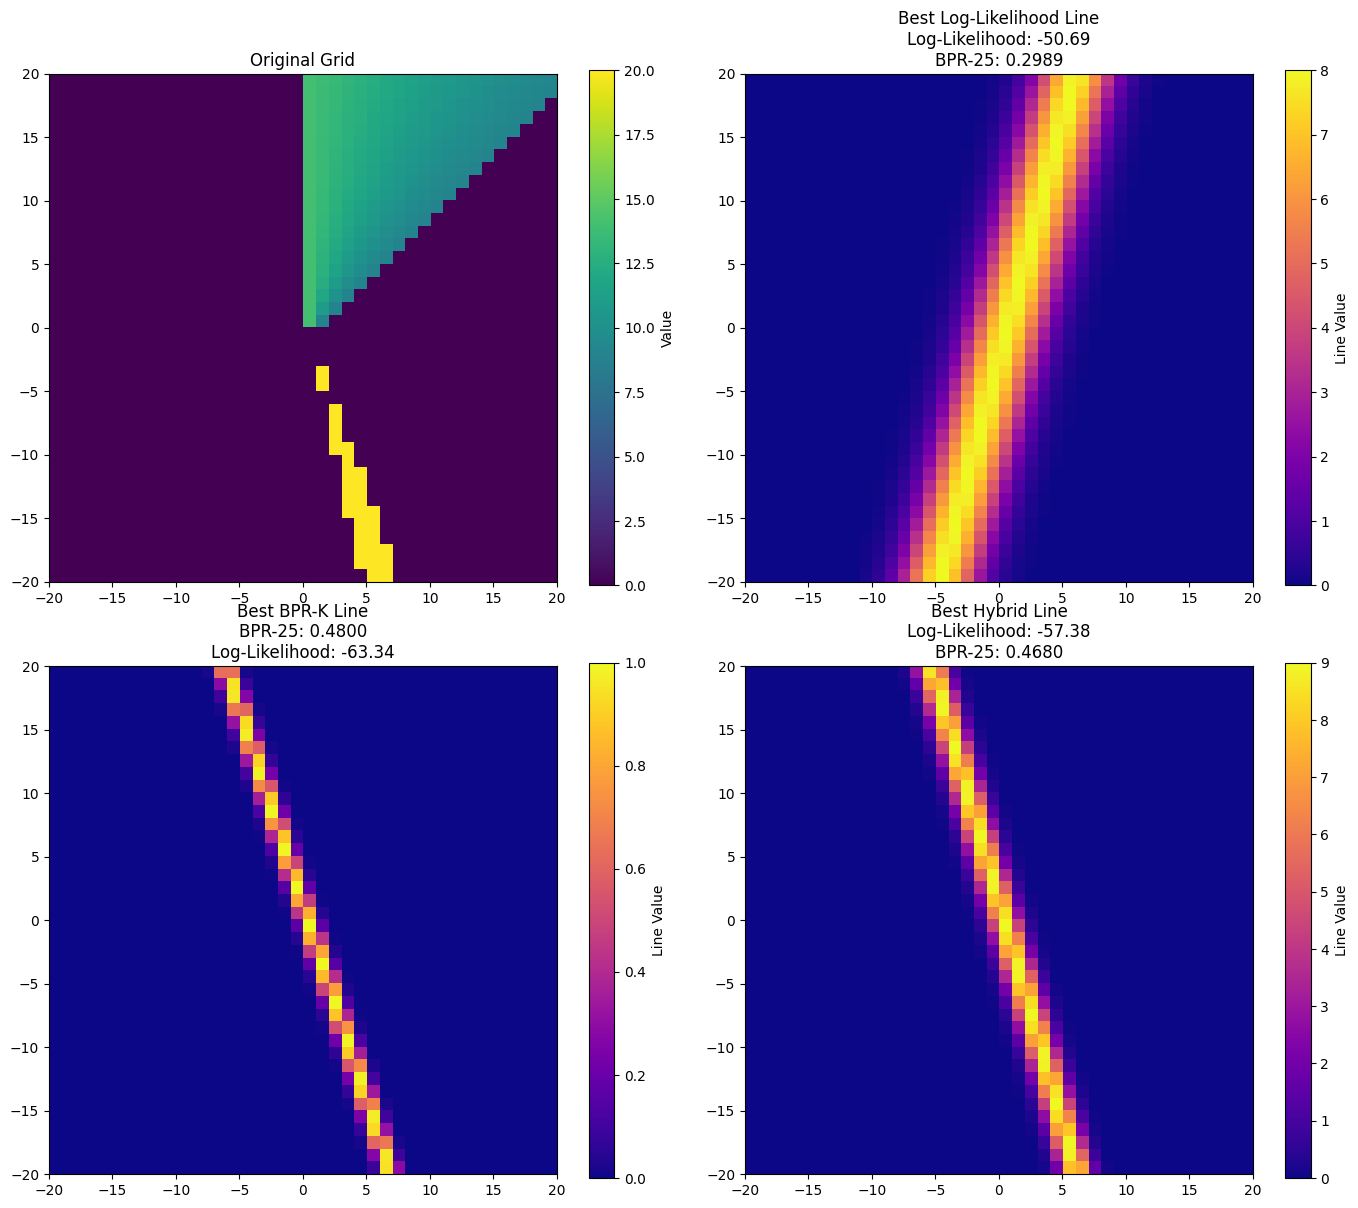

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def create_circular_gradient(size=40):
    # Create a grid of coordinates
    y, x = np.ogrid[-size/2:size/2, -size/2:size/2]
    
    # Calculate the angle for each point
    angle = np.arctan2(y, x)
    
    # Create the base grid with default value 0
    grid = np.zeros((size, size))
    
    # Create the gradient from 6 o'clock to 9 o'clock
    mask_gradient = (angle >= -np.pi/2) & (angle <= -np.pi/4)
    normalized_angle = (angle[mask_gradient] + np.pi/2) / (np.pi/4)
    grid[mask_gradient] = 14 - 5 * normalized_angle
    
    # Create the narrow band just before 3 o'clock
    distance = np.sqrt(x**2 + y**2)
    angle_degrees = np.degrees(angle) % 360
    mask_band = (angle_degrees >= 70) & (angle_degrees < 78)  & (distance <= size/2)
    grid[mask_band] = 20
    
    return grid

def create_line_grid(size, mag, l, x_start, y_start, angle_deg):
    y, x = np.ogrid[-size/2:size/2, -size/2:size/2]
    angle_rad = np.radians(angle_deg)
    
    # Create a perpendicular vector to the line direction
    perp_x = -np.sin(angle_rad)
    perp_y = np.cos(angle_rad)
    
    # Calculate the perpendicular distance to the line
    distance_perp = (x - x_start) * perp_x + (y - y_start) * perp_y
    
    # Create the grid with the line equation
    line_grid = mag * np.exp(-distance_perp**2 / (2 * (l/10)**2))
    
    return line_grid

def plot_grids(original_grid, line_grid, log_likelihood, total_log_likelihood,):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))
    
    extent = [-20, 20, -20, 20]
    
    # Plot original grid
    im1 = ax1.imshow(original_grid, cmap='viridis', interpolation='nearest', extent=extent)
    ax1.set_title('Original Grid')
    fig.colorbar(im1, ax=ax1, label='Value')
    
    # Plot line grid
    im2 = ax2.imshow(line_grid, cmap='plasma', interpolation='nearest', extent=extent)
    ax2.set_title('Line Grid')
    fig.colorbar(im2, ax=ax2, label='Line Value')
    
    # Plot combined grid
    combined_grid = original_grid + line_grid
    im3 = ax3.imshow(combined_grid, cmap='viridis', interpolation='nearest', extent=extent)
    ax3.set_title('Combined Grid')
    fig.colorbar(im3, ax=ax3, label='Combined Value')
    
    # Plot log-likelihood grid
    im4 = ax4.imshow(log_likelihood, cmap='RdYlBu', interpolation='nearest', extent=extent)
    ax4.set_title(f'Log-Likelihood Grid\nTotal Log-Likelihood: {total_log_likelihood:.2f}')
    fig.colorbar(im4, ax=ax4, label='Log-Likelihood')
    

    
    plt.tight_layout()
    plt.show()

# Set parameters
size = 40
mag = 5  # Magnitude
l = 10   # Length scale
x_start = 0  # Starting x-coordinate (center of the grid)
y_start = 0  # Starting y-coordinate (center of the grid)
angle_deg = 45  # Angle of the line in degrees

# Create grids
original_grid = create_circular_gradient(size)
line_grid = create_line_grid(size, mag, l, x_start, y_start, angle_deg)


import numpy as np
from scipy.stats import norm
def calculate_bpr_k(original_grid, line_grid, k):
    original_flat = original_grid.flatten()
    line_flat = line_grid.flatten()
    top_k_original_indices = np.argsort(original_flat)[-k:]
    denominator = np.sum(original_flat[top_k_original_indices])
    top_k_line_indices = np.argsort(line_flat)[-k:]
    numerator = np.sum(original_flat[top_k_line_indices])
    bpr_k = numerator / denominator
    return bpr_k

def calculate_log_likelihood(original_grid, line_grid, fixed_variance):
    log_likelihood = norm.logpdf(line_grid, loc=original_grid, scale=np.sqrt(fixed_variance))
    total_log_likelihood = np.mean(log_likelihood)
    return total_log_likelihood

def calculate_hybrid_objective(original_grid, line_grid, k, fixed_variance, bpr_weight=20):
    bpr_k = calculate_bpr_k(original_grid, line_grid, k)
    log_likelihood = calculate_log_likelihood(original_grid, line_grid, fixed_variance)
    
    # Combine the objectives
    hybrid_objective = log_likelihood + bpr_weight * bpr_k
    
    return hybrid_objective, log_likelihood, bpr_k

def optimize_line_parameters_hybrid(original_grid, size, mag_range, l_range, angle_range, k, fixed_variance, bpr_weight=20):
    best_hybrid_score = -np.inf
    best_params = None
    best_log_likelihood = None
    best_bpr_k = None
    
    for mag in mag_range:
        for l in l_range:
            for angle_deg in angle_range:
                x_start, y_start = 0, 0
                line_grid = create_line_grid(size, mag, l, x_start, y_start, angle_deg)
                hybrid_score, log_likelihood, bpr_k = calculate_hybrid_objective(original_grid, line_grid, k, fixed_variance, bpr_weight)
                
                if hybrid_score > best_hybrid_score:
                    best_hybrid_score = hybrid_score
                    best_params = (mag, l, angle_deg)
                    best_log_likelihood = log_likelihood
                    best_bpr_k = bpr_k
    
    return best_params, best_hybrid_score, best_log_likelihood, best_bpr_k

def optimize_line_parameters_log_likelihood(original_grid, size, mag_range, l_range, angle_range, fixed_variance):
    best_likelihood = -np.inf
    best_params = None
    
    for mag in mag_range:
        for l in l_range:
            for angle_deg in angle_range:
                x_start, y_start = 0, 0
                line_grid = create_line_grid(size, mag, l, x_start, y_start, angle_deg)
                total_log_likelihood = calculate_log_likelihood(original_grid, line_grid, fixed_variance)
                
                if total_log_likelihood > best_likelihood:
                    best_likelihood = total_log_likelihood
                    best_params = (mag, l, angle_deg)
    
    return best_params, best_likelihood

def optimize_line_parameters_bpr_k(original_grid, size, mag_range, l_range, angle_range, k):
    best_bpr_k = -np.inf
    best_params = None
    
    for mag in mag_range:
        for l in l_range:
            for angle_deg in angle_range:
                x_start, y_start = 0, 0
                line_grid = create_line_grid(size, mag, l, x_start, y_start, angle_deg)
                bpr_k = calculate_bpr_k(original_grid, line_grid, k)
                
                if bpr_k > best_bpr_k:
                    best_bpr_k = bpr_k
                    best_params = (mag, l, angle_deg)
    
    return best_params, best_bpr_k

# Set up parameter ranges
mag_range = np.linspace(1, 10, 10)
l_range = np.linspace(5, 20, 16)
angle_range = np.linspace(0, 359, 360)

# Set the value of K for BPR-K and fixed variance for log-likelihood
k = 25
fixed_variance = 0.2

# Run optimizations
best_params_ll, best_log_likelihood = optimize_line_parameters_log_likelihood(original_grid, size, mag_range, l_range, angle_range, fixed_variance)
best_params_bpr, best_bpr_k = optimize_line_parameters_bpr_k(original_grid, size, mag_range, l_range, angle_range, k)

# Create the best line grids
best_line_grid_ll = create_line_grid(size, best_params_ll[0], best_params_ll[1], 0, 0, best_params_ll[2])
best_line_grid_bpr = create_line_grid(size, best_params_bpr[0], best_params_bpr[1], 0, 0, best_params_bpr[2])

# Calculate cross-comparisons
bpr_k_for_best_ll = calculate_bpr_k(original_grid, best_line_grid_ll, k)
log_likelihood_for_best_bpr = calculate_log_likelihood(original_grid, best_line_grid_bpr, fixed_variance)

# Run hybrid optimization
best_params_hybrid, best_hybrid_score, hybrid_log_likelihood, hybrid_bpr_k = optimize_line_parameters_hybrid(
    original_grid, size, mag_range, l_range, angle_range, k, fixed_variance, bpr_weight=50
)

# Create the best hybrid line grid
best_line_grid_hybrid = create_line_grid(size, best_params_hybrid[0], best_params_hybrid[1], 0, 0, best_params_hybrid[2])

# Print results
print("\nBest Hybrid Optimization Line:")
print(f"Parameters: Magnitude = {best_params_hybrid[0]:.2f}, Length scale = {best_params_hybrid[1]:.2f}, Angle = {best_params_hybrid[2]:.2f} degrees")
print(f"Hybrid Score: {best_hybrid_score:.2f}")
print(f"Log-Likelihood: {hybrid_log_likelihood:.2f}")
print(f"BPR-{k}: {hybrid_bpr_k:.4f}")

# Print results
print("Best Log-Likelihood Line:")
print(f"Parameters: Magnitude = {best_params_ll[0]:.2f}, Length scale = {best_params_ll[1]:.2f}, Angle = {best_params_ll[2]:.2f} degrees")
print(f"Log-Likelihood: {best_log_likelihood:.2f}")
print(f"BPR-{k}: {bpr_k_for_best_ll:.4f}")

print("\nBest BPR-K Line:")
print(f"Parameters: Magnitude = {best_params_bpr[0]:.2f}, Length scale = {best_params_bpr[1]:.2f}, Angle = {best_params_bpr[2]:.2f} degrees")
print(f"BPR-{k}: {best_bpr_k:.4f}")
print(f"Log-Likelihood: {log_likelihood_for_best_bpr:.2f}")

def jitter_points(x, y, amount=0.3):
    return x + np.random.uniform(-amount, amount, len(x)), y + np.random.uniform(-amount, amount, len(y))

def plot_grids_comparison(original_grid, line_grid_ll, line_grid_bpr, log_likelihood_ll, bpr_k_ll, log_likelihood_bpr, bpr_k_bpr, k):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
    
    extent = [-20, 20, -20, 20]
    
    # Plot original grid
    im1 = ax1.imshow(original_grid, cmap='viridis', interpolation='nearest', extent=extent)
    ax1.set_title('Original Grid')
    fig.colorbar(im1, ax=ax1, label='Value')
    
    # Plot best log-likelihood line grid
    im2 = ax2.imshow(line_grid_ll, cmap='plasma', interpolation='nearest', extent=extent)
    ax2.set_title(f'Best Log-Likelihood Line\nLog-Likelihood: {log_likelihood_ll:.2f}\nBPR-{k}: {bpr_k_ll:.4f}')
    fig.colorbar(im2, ax=ax2, label='Line Value')
    
    # Plot best BPR-K line grid
    im3 = ax3.imshow(line_grid_bpr, cmap='plasma', interpolation='nearest', extent=extent)
    ax3.set_title(f'Best BPR-K Line\nBPR-{k}: {bpr_k_bpr:.4f}\nLog-Likelihood: {log_likelihood_bpr:.2f}')
    fig.colorbar(im3, ax=ax3, label='Line Value')
    
    # Plot top K locations for both lines with jittering
    ax4.imshow(original_grid, cmap='viridis', interpolation='nearest', extent=extent, alpha=0.3)
    
    top_k_original = np.argsort(original_grid.flatten())[-k:]
    top_k_ll = np.argsort(line_grid_ll.flatten())[-k:]
    top_k_bpr = np.argsort(line_grid_bpr.flatten())[-k:]
    
    y_orig, x_orig = np.unravel_index(top_k_original, original_grid.shape)
    y_ll, x_ll = np.unravel_index(top_k_ll, line_grid_ll.shape)
    y_bpr, x_bpr = np.unravel_index(top_k_bpr, line_grid_bpr.shape)
    
    # Convert grid coordinates to plot coordinates
    x_orig, y_orig = x_orig - size/2, size/2 - y_orig
    x_ll, y_ll = x_ll - size/2, size/2 - y_ll
    x_bpr, y_bpr = x_bpr - size/2, size/2 - y_bpr
    
    # Apply jittering
    x_orig_jit, y_orig_jit = jitter_points(x_orig, y_orig)
    x_ll_jit, y_ll_jit = jitter_points(x_ll, y_ll)
    x_bpr_jit, y_bpr_jit = jitter_points(x_bpr, y_bpr)
    
    # Plot jittered points
    ax4.scatter(x_orig_jit, y_orig_jit, color='red', label='Top K Original', s=20, alpha=0.7)
    ax4.scatter(x_ll_jit, y_ll_jit, color='blue', label='Top K Log-Likelihood', s=20, alpha=0.7)
    ax4.scatter(x_bpr_jit, y_bpr_jit, color='green', label='Top K BPR', s=20, alpha=0.7)
    
    ax4.legend()
    ax4.set_title(f'Top {k} Locations Comparison (Jittered)')
    ax4.set_xlim(-20, 20)
    ax4.set_ylim(-20, 20)
    
    plt.tight_layout()
    plt.show()
def plot_grids_comparison_with_hybrid(original_grid, line_grid_ll, line_grid_bpr, line_grid_hybrid, 
                                      log_likelihood_ll, bpr_k_ll, log_likelihood_bpr, bpr_k_bpr, 
                                      log_likelihood_hybrid, bpr_k_hybrid, k):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
    
    extent = [-20, 20, -20, 20]
    
    # Plot original grid
    im1 = ax1.imshow(original_grid, cmap='viridis', interpolation='nearest', extent=extent)
    ax1.set_title('Original Grid')
    fig.colorbar(im1, ax=ax1, label='Value')
    
    # Plot best log-likelihood line grid
    im2 = ax2.imshow(line_grid_ll, cmap='plasma', interpolation='nearest', extent=extent)
    ax2.set_title(f'Best Log-Likelihood Line\nLog-Likelihood: {log_likelihood_ll:.2f}\nBPR-{k}: {bpr_k_ll:.4f}')
    fig.colorbar(im2, ax=ax2, label='Line Value')
    
    # Plot best BPR-K line grid
    im3 = ax3.imshow(line_grid_bpr, cmap='plasma', interpolation='nearest', extent=extent)
    ax3.set_title(f'Best BPR-K Line\nBPR-{k}: {bpr_k_bpr:.4f}\nLog-Likelihood: {log_likelihood_bpr:.2f}')
    fig.colorbar(im3, ax=ax3, label='Line Value')
    
    # Plot best hybrid line grid
    im4 = ax4.imshow(line_grid_hybrid, cmap='plasma', interpolation='nearest', extent=extent)
    ax4.set_title(f'Best Hybrid Line\nLog-Likelihood: {log_likelihood_hybrid:.2f}\nBPR-{k}: {bpr_k_hybrid:.4f}')
    fig.colorbar(im4, ax=ax4, label='Line Value')
    
    plt.tight_layout()
    plt.show()

# Plot the results including the hybrid optimization
plot_grids_comparison_with_hybrid(original_grid, best_line_grid_ll, best_line_grid_bpr, best_line_grid_hybrid,
                                  best_log_likelihood, bpr_k_for_best_ll, 
                                  log_likelihood_for_best_bpr, best_bpr_k,
                                  hybrid_log_likelihood, hybrid_bpr_k, k)

Best Log-Likelihood Line:
Parameters: Magnitude = 11.00, Length scale = 30.00, Angle = 83.00 degrees
Log-Likelihood: -45.52
BPR-25: 0.4212

Best BPR-K Line:
Parameters: Magnitude = 9.00, Length scale = 22.00, Angle = 270.00 degrees
BPR-25: 0.7388
Log-Likelihood: -48.96

Best Hybrid Optimization Line:
Parameters: Magnitude = 11.00, Length scale = 30.00, Angle = 270.00 degrees
Log-Likelihood: -45.97
BPR-25: 0.7360


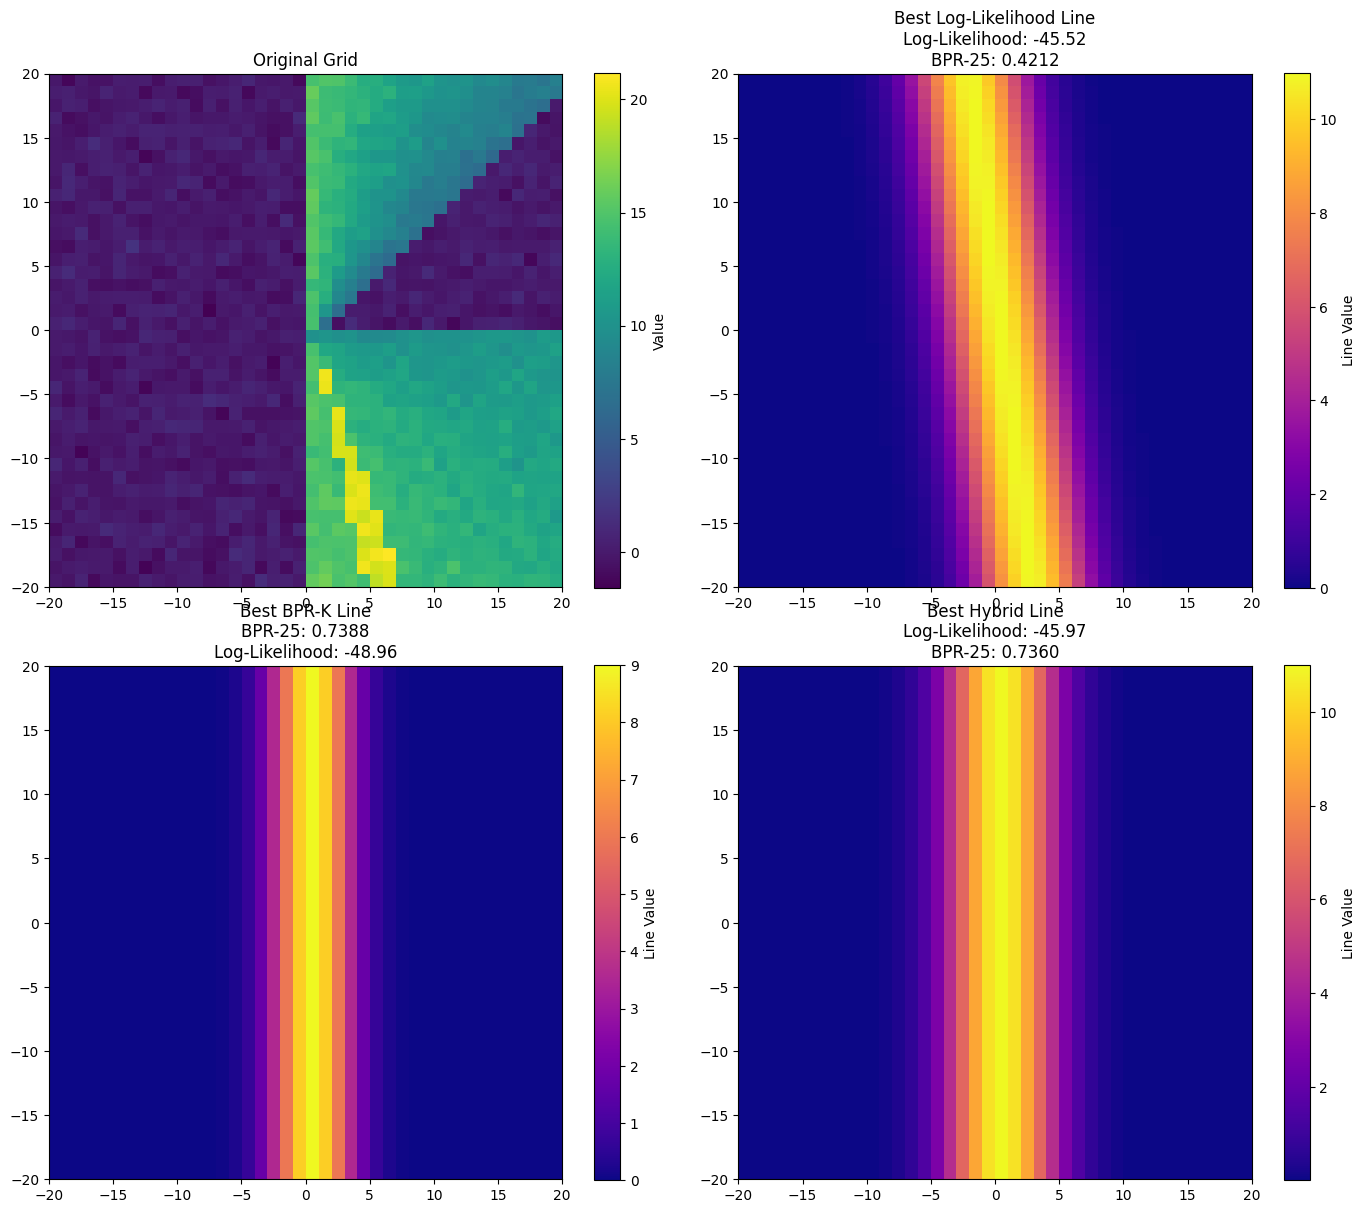

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def create_complex_circular_gradient(size=40):
    y, x = np.ogrid[-size/2:size/2, -size/2:size/2]
    angle = np.arctan2(y, x)
    distance = np.sqrt(x**2 + y**2)
    
    grid = np.zeros((size, size))
    
    # Create a gradient from 6 o'clock to 9 o'clock
    mask_gradient1 = (angle >= -np.pi/2) & (angle <= -np.pi/4)
    normalized_angle1 = (angle[mask_gradient1] + np.pi/2) / (np.pi/4)
    grid[mask_gradient1] = 15 - 8 * normalized_angle1
    
    # Create a gradient from 12 o'clock to 3 o'clock
    mask_gradient2 = (angle >= 0) & (angle <= np.pi/2)
    normalized_angle2 = angle[mask_gradient2] / (np.pi/2)
    grid[mask_gradient2] = 10 + 5 * normalized_angle2
    
    # Create a narrow band just before 3 o'clock
    angle_degrees = np.degrees(angle) % 360
    mask_band = (angle_degrees >= 70) & (angle_degrees < 78) & (distance <= size/2)
    grid[mask_band] = 20
    
    # Add some noise
    grid += np.random.normal(0, 0.5, grid.shape)
    
    return grid

def create_line_grid(size, mag, l, x_start, y_start, angle_deg):
    y, x = np.ogrid[-size/2:size/2, -size/2:size/2]
    angle_rad = np.radians(angle_deg)
    
    perp_x = -np.sin(angle_rad)
    perp_y = np.cos(angle_rad)
    
    distance_perp = (x - x_start) * perp_x + (y - y_start) * perp_y
    
    line_grid = mag * np.exp(-distance_perp**2 / (2 * (l/10)**2))
    
    return line_grid

def calculate_bpr_k(original_grid, line_grid, k):
    original_flat = original_grid.flatten()
    line_flat = line_grid.flatten()
    top_k_original_indices = np.argsort(original_flat)[-k:]
    denominator = np.sum(original_flat[top_k_original_indices])
    top_k_line_indices = np.argsort(line_flat)[-k:]
    numerator = np.sum(original_flat[top_k_line_indices])
    bpr_k = numerator / denominator
    return bpr_k

def calculate_log_likelihood(original_grid, line_grid, fixed_variance):
    log_likelihood = norm.logpdf(line_grid, loc=original_grid, scale=np.sqrt(fixed_variance))
    total_log_likelihood = np.mean(log_likelihood)
    return total_log_likelihood

def calculate_hybrid_objective(original_grid, line_grid, k, fixed_variance, bpr_weight):
    bpr_k = calculate_bpr_k(original_grid, line_grid, k)
    log_likelihood = calculate_log_likelihood(original_grid, line_grid, fixed_variance)
    
    hybrid_objective = log_likelihood + bpr_weight * bpr_k
    
    return hybrid_objective, log_likelihood, bpr_k

def optimize_line_parameters(original_grid, size, mag_range, l_range, angle_range, k, fixed_variance, bpr_weight, objective_type):
    best_score = -np.inf
    best_params = None
    best_log_likelihood = None
    best_bpr_k = None
    
    for mag in mag_range:
        for l in l_range:
            for angle_deg in angle_range:
                line_grid = create_line_grid(size, mag, l, 0, 0, angle_deg)
                
                if objective_type == 'hybrid':
                    score, log_likelihood, bpr_k = calculate_hybrid_objective(original_grid, line_grid, k, fixed_variance, bpr_weight)
                elif objective_type == 'log_likelihood':
                    score = calculate_log_likelihood(original_grid, line_grid, fixed_variance)
                    bpr_k = calculate_bpr_k(original_grid, line_grid, k)
                elif objective_type == 'bpr_k':
                    score = calculate_bpr_k(original_grid, line_grid, k)
                    log_likelihood = calculate_log_likelihood(original_grid, line_grid, fixed_variance)
                
                if score > best_score:
                    best_score = score
                    best_params = (mag, l, angle_deg)
                    best_log_likelihood = log_likelihood if objective_type != 'log_likelihood' else score
                    best_bpr_k = bpr_k if objective_type != 'bpr_k' else score
    
    return best_params, best_score, best_log_likelihood, best_bpr_k

# Set up parameters
size = 40
mag_range = np.linspace(1, 20, 20)
l_range = np.linspace(5, 30, 26)
angle_range = np.linspace(0, 359, 360)
k = 25
fixed_variance = 0.5
bpr_weight = 20

# Create the complex circular gradient
original_grid = create_complex_circular_gradient(size)

# Run optimizations
best_params_ll, _, best_log_likelihood, bpr_k_ll = optimize_line_parameters(original_grid, size, mag_range, l_range, angle_range, k, fixed_variance, bpr_weight, 'log_likelihood')
best_params_bpr, _, log_likelihood_bpr, best_bpr_k = optimize_line_parameters(original_grid, size, mag_range, l_range, angle_range, k, fixed_variance, bpr_weight, 'bpr_k')
best_params_hybrid, _, hybrid_log_likelihood, hybrid_bpr_k = optimize_line_parameters(original_grid, size, mag_range, l_range, angle_range, k, fixed_variance, bpr_weight, 'hybrid')

# Create the best line grids
best_line_grid_ll = create_line_grid(size, best_params_ll[0], best_params_ll[1], 0, 0, best_params_ll[2])
best_line_grid_bpr = create_line_grid(size, best_params_bpr[0], best_params_bpr[1], 0, 0, best_params_bpr[2])
best_line_grid_hybrid = create_line_grid(size, best_params_hybrid[0], best_params_hybrid[1], 0, 0, best_params_hybrid[2])

# Print results
print("Best Log-Likelihood Line:")
print(f"Parameters: Magnitude = {best_params_ll[0]:.2f}, Length scale = {best_params_ll[1]:.2f}, Angle = {best_params_ll[2]:.2f} degrees")
print(f"Log-Likelihood: {best_log_likelihood:.2f}")
print(f"BPR-{k}: {bpr_k_ll:.4f}")

print("\nBest BPR-K Line:")
print(f"Parameters: Magnitude = {best_params_bpr[0]:.2f}, Length scale = {best_params_bpr[1]:.2f}, Angle = {best_params_bpr[2]:.2f} degrees")
print(f"BPR-{k}: {best_bpr_k:.4f}")
print(f"Log-Likelihood: {log_likelihood_bpr:.2f}")

print("\nBest Hybrid Optimization Line:")
print(f"Parameters: Magnitude = {best_params_hybrid[0]:.2f}, Length scale = {best_params_hybrid[1]:.2f}, Angle = {best_params_hybrid[2]:.2f} degrees")
print(f"Log-Likelihood: {hybrid_log_likelihood:.2f}")
print(f"BPR-{k}: {hybrid_bpr_k:.4f}")

def plot_grids_comparison(original_grid, line_grid_ll, line_grid_bpr, line_grid_hybrid, 
                          log_likelihood_ll, bpr_k_ll, log_likelihood_bpr, bpr_k_bpr, 
                          log_likelihood_hybrid, bpr_k_hybrid, k):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
    
    extent = [-20, 20, -20, 20]
    
    # Plot original grid
    im1 = ax1.imshow(original_grid, cmap='viridis', interpolation='nearest', extent=extent)
    ax1.set_title('Original Grid')
    fig.colorbar(im1, ax=ax1, label='Value')
    
    # Plot best log-likelihood line grid
    im2 = ax2.imshow(line_grid_ll, cmap='plasma', interpolation='nearest', extent=extent)
    ax2.set_title(f'Best Log-Likelihood Line\nLog-Likelihood: {log_likelihood_ll:.2f}\nBPR-{k}: {bpr_k_ll:.4f}')
    fig.colorbar(im2, ax=ax2, label='Line Value')
    
    # Plot best BPR-K line grid
    im3 = ax3.imshow(line_grid_bpr, cmap='plasma', interpolation='nearest', extent=extent)
    ax3.set_title(f'Best BPR-K Line\nBPR-{k}: {bpr_k_bpr:.4f}\nLog-Likelihood: {log_likelihood_bpr:.2f}')
    fig.colorbar(im3, ax=ax3, label='Line Value')
    
    # Plot best hybrid line grid
    im4 = ax4.imshow(line_grid_hybrid, cmap='plasma', interpolation='nearest', extent=extent)
    ax4.set_title(f'Best Hybrid Line\nLog-Likelihood: {log_likelihood_hybrid:.2f}\nBPR-{k}: {bpr_k_hybrid:.4f}')
    fig.colorbar(im4, ax=ax4, label='Line Value')
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_grids_comparison(original_grid, best_line_grid_ll, best_line_grid_bpr, best_line_grid_hybrid,
                      best_log_likelihood, bpr_k_ll, 
                      log_likelihood_bpr, best_bpr_k,
                      hybrid_log_likelihood, hybrid_bpr_k, k)

In [2]:

import numpy as np
from scipy.stats import norm
def calculate_bpr_k(original_grid, line_grid, k):
    original_flat = original_grid.flatten()
    line_flat = line_grid.flatten()
    top_k_original_indices = np.argsort(original_flat)[-k:]
    denominator = np.sum(original_flat[top_k_original_indices])
    top_k_line_indices = np.argsort(line_flat)[-k:]
    numerator = np.sum(original_flat[top_k_line_indices])
    bpr_k = numerator / denominator
    return bpr_k

def calculate_log_likelihood(original_grid, line_grid, fixed_variance):
    log_likelihood = norm.logpdf(line_grid, loc=original_grid, scale=np.sqrt(fixed_variance))
    total_log_likelihood = np.sum(log_likelihood)
    return total_log_likelihood

def optimize_line_parameters_log_likelihood(original_grid, size, mag_range, l_range, angle_range, fixed_variance):
    best_likelihood = -np.inf
    best_params = None
    
    for mag in mag_range:
        for l in l_range:
            for angle_deg in angle_range:
                x_start, y_start = 0, 0
                line_grid = create_line_grid(size, mag, l, x_start, y_start, angle_deg)
                total_log_likelihood = calculate_log_likelihood(original_grid, line_grid, fixed_variance)
                
                if total_log_likelihood > best_likelihood:
                    best_likelihood = total_log_likelihood
                    best_params = (mag, l, angle_deg)
    
    return best_params, best_likelihood

def optimize_line_parameters_bpr_k(original_grid, size, mag_range, l_range, angle_range, k):
    best_bpr_k = -np.inf
    best_params = None
    
    for mag in mag_range:
        for l in l_range:
            for angle_deg in angle_range:
                x_start, y_start = 0, 0
                line_grid = create_line_grid(size, mag, l, x_start, y_start, angle_deg)
                bpr_k = calculate_bpr_k(original_grid, line_grid, k)
                
                if bpr_k > best_bpr_k:
                    best_bpr_k = bpr_k
                    best_params = (mag, l, angle_deg)
    
    return best_params, best_bpr_k

# Set up parameter ranges
mag_range = np.linspace(1, 10, 10)
l_range = np.linspace(5, 20, 16)
angle_range = np.linspace(0, 359, 360)

# Set the value of K for BPR-K and fixed variance for log-likelihood
k = 25
fixed_variance = 0.2

# Run optimizations
best_params_ll, best_log_likelihood = optimize_line_parameters_log_likelihood(original_grid, size, mag_range, l_range, angle_range, fixed_variance)
best_params_bpr, best_bpr_k = optimize_line_parameters_bpr_k(original_grid, size, mag_range, l_range, angle_range, k)

# Create the best line grids
best_line_grid_ll = create_line_grid(size, best_params_ll[0], best_params_ll[1], 0, 0, best_params_ll[2])
best_line_grid_bpr = create_line_grid(size, best_params_bpr[0], best_params_bpr[1], 0, 0, best_params_bpr[2])

# Calculate cross-comparisons
bpr_k_for_best_ll = calculate_bpr_k(original_grid, best_line_grid_ll, k)
log_likelihood_for_best_bpr = calculate_log_likelihood(original_grid, best_line_grid_bpr, fixed_variance)

# Print results
print("Best Log-Likelihood Line:")
print(f"Parameters: Magnitude = {best_params_ll[0]:.2f}, Length scale = {best_params_ll[1]:.2f}, Angle = {best_params_ll[2]:.2f} degrees")
print(f"Log-Likelihood: {best_log_likelihood:.2f}")
print(f"BPR-{k}: {bpr_k_for_best_ll:.4f}")

print("\nBest BPR-K Line:")
print(f"Parameters: Magnitude = {best_params_bpr[0]:.2f}, Length scale = {best_params_bpr[1]:.2f}, Angle = {best_params_bpr[2]:.2f} degrees")
print(f"BPR-{k}: {best_bpr_k:.4f}")
print(f"Log-Likelihood: {log_likelihood_for_best_bpr:.2f}")

def jitter_points(x, y, amount=0.3):
    return x + np.random.uniform(-amount, amount, len(x)), y + np.random.uniform(-amount, amount, len(y))

def plot_grids_comparison(original_grid, line_grid_ll, line_grid_bpr, log_likelihood_ll, bpr_k_ll, log_likelihood_bpr, bpr_k_bpr, k):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
    
    extent = [-20, 20, -20, 20]
    
    # Plot original grid
    im1 = ax1.imshow(original_grid, cmap='viridis', interpolation='nearest', extent=extent)
    ax1.set_title('Original Grid')
    fig.colorbar(im1, ax=ax1, label='Value')
    
    # Plot best log-likelihood line grid
    im2 = ax2.imshow(line_grid_ll, cmap='plasma', interpolation='nearest', extent=extent)
    ax2.set_title(f'Best Log-Likelihood Line\nLog-Likelihood: {log_likelihood_ll:.2f}\nBPR-{k}: {bpr_k_ll:.4f}')
    fig.colorbar(im2, ax=ax2, label='Line Value')
    
    # Plot best BPR-K line grid
    im3 = ax3.imshow(line_grid_bpr, cmap='plasma', interpolation='nearest', extent=extent)
    ax3.set_title(f'Best BPR-K Line\nBPR-{k}: {bpr_k_bpr:.4f}\nLog-Likelihood: {log_likelihood_bpr:.2f}')
    fig.colorbar(im3, ax=ax3, label='Line Value')
    
    # Plot top K locations for both lines with jittering
    ax4.imshow(original_grid, cmap='viridis', interpolation='nearest', extent=extent, alpha=0.3)
    
    top_k_original = np.argsort(original_grid.flatten())[-k:]
    top_k_ll = np.argsort(line_grid_ll.flatten())[-k:]
    top_k_bpr = np.argsort(line_grid_bpr.flatten())[-k:]
    
    y_orig, x_orig = np.unravel_index(top_k_original, original_grid.shape)
    y_ll, x_ll = np.unravel_index(top_k_ll, line_grid_ll.shape)
    y_bpr, x_bpr = np.unravel_index(top_k_bpr, line_grid_bpr.shape)
    
    # Convert grid coordinates to plot coordinates
    x_orig, y_orig = x_orig - size/2, size/2 - y_orig
    x_ll, y_ll = x_ll - size/2, size/2 - y_ll
    x_bpr, y_bpr = x_bpr - size/2, size/2 - y_bpr
    
    # Apply jittering
    x_orig_jit, y_orig_jit = jitter_points(x_orig, y_orig)
    x_ll_jit, y_ll_jit = jitter_points(x_ll, y_ll)
    x_bpr_jit, y_bpr_jit = jitter_points(x_bpr, y_bpr)
    
    # Plot jittered points
    ax4.scatter(x_orig_jit, y_orig_jit, color='red', label='Top K Original', s=20, alpha=0.7)
    ax4.scatter(x_ll_jit, y_ll_jit, color='blue', label='Top K Log-Likelihood', s=20, alpha=0.7)
    ax4.scatter(x_bpr_jit, y_bpr_jit, color='green', label='Top K BPR', s=20, alpha=0.7)
    
    ax4.legend()
    ax4.set_title(f'Top {k} Locations Comparison (Jittered)')
    ax4.set_xlim(-20, 20)
    ax4.set_ylim(-20, 20)
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_grids_comparison(original_grid, best_line_grid_ll, best_line_grid_bpr, 
                      best_log_likelihood, bpr_k_for_best_ll, 
                      log_likelihood_for_best_bpr, best_bpr_k, k)

NameError: name 'original_grid' is not defined

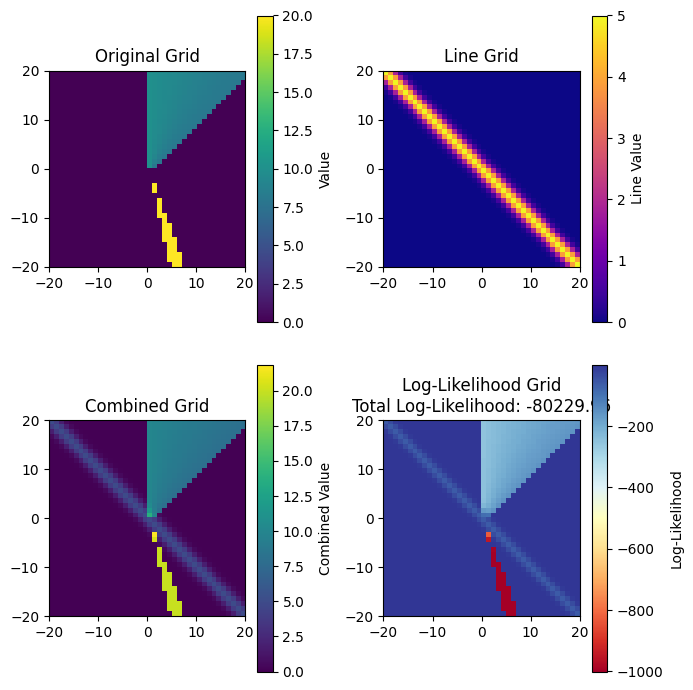

Original Grid:
[[0.         0.         0.         ... 8.2060206  8.13390167 8.06528003]
 [0.         0.         0.         ... 8.14132578 8.06880701 8.        ]
 [0.         0.         0.         ... 8.07273676 8.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Line Grid:
[[5.00000000e+000 3.89400392e+000 1.83939721e+000 ... 1.15261316e-148
  8.29205239e-157 3.61820576e-165]
 [3.89400392e+000 5.00000000e+000 3.89400392e+000 ... 9.71757425e-141
  1.15261316e-148 8.29205239e-157]
 [1.83939721e+000 3.89400392e+000 5.00000000e+000 ... 4.96918221e-133
  9.71757425e-141 1.15261316e-148]
 ...
 [1.15261316e-148 9.71757425e-141 4.96918221e-133 ... 5.00000000e+000
  3.89400392e+000 1.83939721e+000]
 [8.29205239e-157 1.15261316e-148 9.71757425e-141 ... 3.89400392e+000
  5.00000000e+000 3.89400392e+000]